<a href="https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/HomeStylist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">HomeStylist v.1.0</font></b>

![visitors](https://visitor-badge.glitch.me/badge?page_id=mlart.HomeStylist&left_color=black&right_color=orange)

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [pose-with-style](https://github.com/BadourAlBahar/pose-with-style)

**Article**: [Pose with Style: Detail-Preserving Pose-Guided Image Synthesis with Conditional StyleGAN](https://pose-with-style.github.io/asset/paper.pdf)

**Creators:** *Badour Albahar, Jingwan Lu, Jimei Yang, Zhixin Shu, Eli Shechtman, Jia-Bin Huang*

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@MLArt](https://t.me/MLArt),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, поочередно нажимайте на кнопки (куда указывают красные стрелки), дожидаясь завершения выполнения каждого блока.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary libraries (~3 min.)</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить все необходимые библиотеки (~3 мин.)</font></b>

import os
import cv2
import PIL
import glob
import torch
import os.path
import numpy as np
from PIL import Image
from tqdm import tqdm
from shutil import copyfile
from google.colab import files
from IPython.display import clear_output

%cd /content
!rm -rf /content/PWS
!git clone https://github.com/BadourAlBahar/pose-with-style PWS
!mkdir /content/PWS/checkpoints /content/PWS/test_data /content/PWS/result
!pip install -r /content/PWS/requirements.txt
!wget https://filebox.ece.vt.edu/~Badour/pose-with-style/downloads/dp_uv_lookup_256.npy -O /content/PWS/util/dp_uv_lookup_256.npy
!wget https://filebox.ece.vt.edu/~Badour/pose-with-style/downloads/uv_space_parts.npy -O /content/PWS/util/uv_space_parts.npy
!wget https://filebox.ece.vt.edu/~Badour/pose-with-style/pretrained/posewithstyle.pt -O /content/PWS/checkpoints/posewithstyle.pt
!wget https://filebox.ece.vt.edu/~Badour/pose-with-style/downloads/CCM_epoch50.pt -O /content/PWS/checkpoints/CCM_epoch50.pt

%cd /content
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%cd /content
!rm -rf /content/detectron2
!git clone https://github.com/facebookresearch/detectron2.git
!python -m pip install -e detectron2
!pip install av

%cd /content
!rm -rf /content/U-2-Net
!git clone https://github.com/xuebinqin/U-2-Net
%cd /content/U-2-Net
!set -exo
!gdown --id 1-Yg0cxgrNhHP-016FPdp902BR-kSsA4P
%cd /content

if [len(os.listdir('/content/PWS/checkpoints')) == 2,
    len(os.listdir('/content/PWS/util')) == 8,
    os.path.isfile('/content/U-2-Net/u2net_human_seg.pth')]:
  clear_output()
  print('Done!')

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Initializing libraries and weights</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Инициализируем бибилиотеки и веса</font></b>
%cd /content/U-2-Net
try: os.rename('/content/U-2-Net/model', '/content/U-2-Net/model_u2n')
except: pass
from skimage import io, transform
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset
from model_u2n import U2NET # full size version 173.6 MB

def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d-mi)/(ma-mi)
    return dn

def save_output(image_name,pred,d_dir,outline_depth):
    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()
    im = PIL.Image.fromarray(predict_np*255).convert('RGB')
    img_name = image_name.split(os.sep)[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1],image.shape[0]),resample=PIL.Image.BILINEAR)
    pb_np = np.array(imo)
    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]
    image = cv2.cvtColor(np.array(imo), cv2.COLOR_BGR2GRAY)
    if outline_depth != 0:
      contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      cv2.drawContours(image, contours, -1, (255,255,255), outline_depth)
    cv2.imwrite(f'{d_dir}/{imidx}_sil.png',image)

model_dir = '/content/U-2-Net/u2net_human_seg.pth'
print('downloading 173.6 MB...')
net_u = U2NET(3,1)
if torch.cuda.is_available():
    net_u.load_state_dict(torch.load(model_dir))
    net_u.cuda()
else: net_u.load_state_dict(torch.load(model_dir, map_location='cpu'))
net_u.eval()

%cd /content
clear_output()
print('Done!')

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Create pickle2png converter</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Создать pickle2png конвертер</font></b>

%%writefile /content/detectron2/projects/DensePose/pickle2png.py
import pickle
import numpy as np
from PIL import Image
import argparse
import os

def save_image(image_numpy, image_path):
    image_pil = Image.fromarray(image_numpy.astype(np.uint8))
    image_pil.save(image_path)

parser = argparse.ArgumentParser()
parser.add_argument('--pickle_file', type=str, help="path to pickle file")
parser.add_argument("--save_path", type=str, help="path to save the png images")
args = parser.parse_args()

# READING
f = open(args.pickle_file, 'rb')
data = pickle.load(f)
data_size = len(data)
print ('Will process %d images'%data_size)

# save path
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

for img_id in range(data_size):
    # assuming we always have 1 person
    name = data[img_id]['file_name']
    iuv_image_name = name.split('/')[-1].split('.')[0]+ '_iuv.png'
    iuv_name =  os.path.join(args.save_path, iuv_image_name)
    size = np.array(Image.open(name).convert('RGB')).shape
    wrapped_iuv = np.zeros(size)

    print ('Processing %d/%d: %s'%(img_id+1, data_size, iuv_image_name))
    num_instances = len(data[img_id]['scores'])
    if num_instances is 0:
        print ('%s has no person.'%iuv_image_name)
        file_object.write(iuv_image_name+'\n')
    else:
        # get results - process first detected human
        instance_id = 0
        # process highest score detected human
        # instance_id = data[img_id]['scores'].numpy().tolist().index(max(data[img_id]['scores'].numpy().tolist()))
        pred_densepose_result = data[img_id]['pred_densepose'][instance_id]
        bbox_xyxy = data[img_id]['pred_boxes_XYXY'][instance_id]
        i = pred_densepose_result.labels
        uv = pred_densepose_result.uv * 255
        pre_iuv = np.expand_dims(i.cpu(), 0)
        iuv = np.concatenate((pre_iuv, uv.cpu()), axis=0)
        # 3xhxw to hxwx3
        iuv_arr = np.transpose(iuv, (1, 2, 0))
        # wrap iuv to size of image
        wrapped_iuv[int(bbox_xyxy[1]):iuv_arr.shape[0]+int(bbox_xyxy[1]), int(bbox_xyxy[0]):iuv_arr.shape[1]+int(bbox_xyxy[0]), :] = iuv_arr
        save_image(wrapped_iuv, iuv_name)

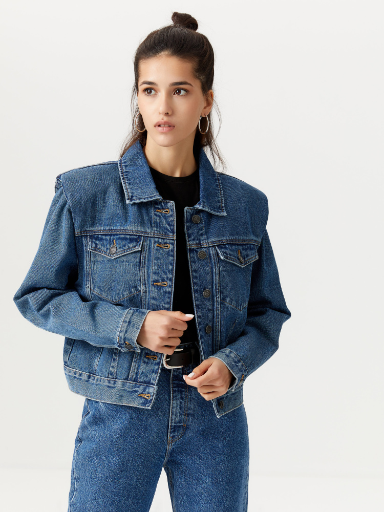

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload photo with source pose</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить фото с исходным положением тела</font></b>
!rm -rf /content/PWS/test_data/source*
uploaded = files.upload()
for source in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=source, length=len(uploaded[source])))

file_type = source.split('.')[-1]
os.rename(source, '/content/PWS/test_data/source.'+file_type)
source = '/content/PWS/test_data/source.'+file_type

image = cv2.imread(source, cv2.IMREAD_COLOR)
h, w, _ = image.shape
if w > h: image = cv2.resize(image, (512, int((h*512)/w)))
elif h > w: image = cv2.resize(image, (int((w*512)/h), 512))
else: image = cv2.resize(image, (512, 512))
cv2.imwrite('/content/PWS/test_data/source.png', image)
!rm -rf $source

if os.path.isfile(source):
  clear_output()
  Image.open('/content/PWS/test_data/source.png')

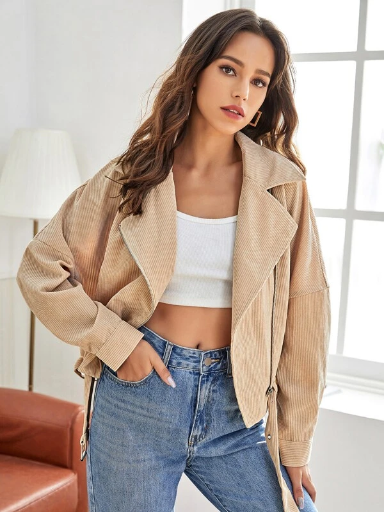

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload photo with target pose</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить фото с итоговым положением тела</font></b>
!rm -rf /content/PWS/test_data/target*
uploaded = files.upload()
for target in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=target, length=len(uploaded[target])))

file_type = target.split('.')[-1]
os.rename(target, '/content/PWS/test_data/target.'+file_type)
target = '/content/PWS/test_data/target.'+file_type

image = cv2.imread(target, cv2.IMREAD_COLOR)
h, w, _ = image.shape
if w > h: image = cv2.resize(image, (512, int((h*512)/w)))
elif h > w: image = cv2.resize(image, (int((w*512)/h), 512))
else: image = cv2.resize(image, (512, 512))
cv2.imwrite('/content/PWS/test_data/target.png', image)
!rm -rf $target

if os.path.isfile(target):
  clear_output()
  Image.open('/content/PWS/test_data/source.png')

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Compute densepose and mask</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Посчитать карту плотности поз и маску</font></b>

%cd /content/detectron2/projects/DensePose
data_folder = '/content/PWS/test_data'
!rm -rf /content/PWS/test_data/.ipynb_checkpoints
!rm -rf /content/PWS/test_data/source_sil.png /content/PWS/test_data/target_sil.png
!rm -rf /content/PWS/test_data/source_iuv.png /content/PWS/test_data/target_iuv.png

images_paths = glob.glob(data_folder + os.sep + '*')

outline_depth = 5 # толщина контура
test_salobj_dataset = SalObjDataset(img_name_list = images_paths, lbl_name_list = [], transform=transforms.Compose([RescaleT(320),ToTensorLab(flag=0)]))
test_salobj_dataloader = DataLoader(test_salobj_dataset, batch_size=1, shuffle=False, num_workers=1)
for i_test, data_test in tqdm(enumerate(test_salobj_dataloader)):
  print('\nStage 1/2\n')
  inputs_test = data_test['image']
  inputs_test = inputs_test.type(torch.FloatTensor)
  inputs_test = Variable(inputs_test.cuda())
  d1,d2,d3,d4,d5,d6,d7= net_u(inputs_test)
  pred = normPRED(d1[:,0,:,:])
  save_output(images_paths[i_test],pred,data_folder,outline_depth)
  del d1,d2,d3,d4,d5,d6,d7
  clear_output()

for i in tqdm(images_paths):
  print('\nStage 2/2\n')
  !python apply_net.py dump configs/densepose_rcnn_R_50_FPN_s1x.yaml \
    https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
    $i --output /content/dump.pkl -v
  !python pickle2png.py \
    --pickle_file /content/dump.pkl \
    --save_path $data_folder
  clear_output()

if len(os.listdir('/content/PWS/test_data')) == 6:
  clear_output()
  print('Done!')

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Process (~ 1 min.)</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Запуск (~ 1 мин.)</font></b>

%cd /content/PWS
!rm -rf /content/PWS/result/*
process_type = "repose" #@param ["repose", "garment_transfer"]
if_garment_transfer_then = "upper_body" #@param ["upper_body", "lower_body", "face"]

if process_type == "repose":
  !CUDA_VISIBLE_DEVICES=0 python inference.py \
    --input_path ./test_data \
    --input_name source \
    --target_name target \
    --CCM_pretrained_model /content/PWS/checkpoints/CCM_epoch50.pt \
    --pretrained_model /content/PWS/checkpoints/posewithstyle.pt \
    --save_path /content/PWS/result
else:
  !CUDA_VISIBLE_DEVICES=0 python garment_transfer.py \
    --input_path ./test_data \
    --input_name source \
    --target_name target \
    --CCM_pretrained_model /content/PWS/checkpoints/CCM_epoch50.pt \
    --pretrained_model /content/PWS/checkpoints/posewithstyle.pt \
    --part $if_garment_transfer_then \
    --save_path /content/PWS/result

if len(os.listdir('/content/PWS/result')) > 0:
  clear_output()
  if process_type == "repose":
    im = Image.open('/content/PWS/result/source_2_target_vis.png')
  else:
    im = Image.open('/content/PWS/result/source_and_target_upper_body_vis.png')

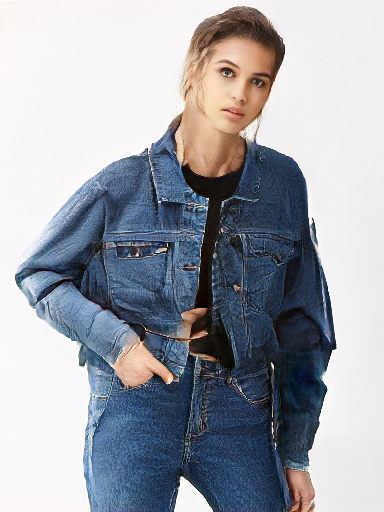

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Show result</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Показать результат</font></b>

im